In [2]:
!pip install scipy


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
## imports

In [4]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import numpy as np

In [34]:

filepath = './datasets/basic_motions/BasicMotions_TRAIN.arff'
def load_dataset_to_dataframe(path):
    """Load data that is stored within the path

    Args:
        path: string with path containing data
    Returns:
        A pandas dataframe with only data inside
    """
    dataset = arff.loadarff(path)
    df = pd.DataFrame(dataset[0])
    return df 
df = load_dataset_to_dataframe(filepath)

In [103]:
#print(df.iloc[0,0].shape[0])

def stack_time_series(df):
    """This function creates new dataframe without segmentation and classification

    Args:
        df: segmented dataframe
    Returns:
        A pandas dataframe with shape [dimensions of input data,original count of time series]
    """
    dimensionality = df.iloc[0,0].shape[0] # assumption that data dimensionality is the number of rows of first element in dataframe
    # also the first column is expected to store data (second stores classification)
    
    # creating new data frame 
    stacked = pd.DataFrame(index=np.arange(dimensionality), columns=np.arange(1))
    
    # filling it with empty numpy arrays
    for i in range(dimensionality):
        stacked.iloc[i, 0] = np.array([])
    # filling the dataframe with data    
    for index, row in df.iterrows():
        i = 0
        for r in row[0]:
             stacked.iloc[i,0] = np.concatenate((stacked.iloc[i,0],np.array(r.tolist())))
             i += 1
    return stacked
   
stacked = stack_time_series(df)
#print(df.iloc[0,0][1])
print(stacked)

6
                                                   0
0  [0.079106, 0.079106, -0.903497, 1.116125, 1.63...
1  [0.394032, 0.394032, -3.666397, -0.656101, 1.4...
2  [0.551444, 0.551444, -0.282844, 0.333118, 0.39...
3  [0.351565, 0.351565, -0.095881, 1.624657, 1.18...
4  [0.02397, 0.02397, -0.319605, -0.569962, -0.27...
5  [0.633883, 0.633883, 0.972131, 1.209171, 1.739...


In [88]:
len(df['relationalAtt'].iloc[0]) 
# dane są 6 wymiarowe ponieważ mam dwe zmienne 3 wymiarowe
# najpierw x y z dla akcelerometra
# potem x y z żyroskopu

6

In [89]:
len(df['relationalAtt'].iloc[0][0])

100

In [89]:
print(df['relationalAtt'].iloc[0][1])

(0.756509, 0.756509, -9.21697, -5.977115, -3.711996, -3.711996, 0.731686, 1.070128, 0.582956, 0.65684, 0.738943, 0.738943, 0.623878, 0.623878, 0.342349, 0.342349, 0.487381, 0.480404, 0.430157, 0.447453, 0.249743, 0.2423, 0.450441, 0.309654, 0.083404, 0.292108, 0.311343, 0.543993, 0.698218, 0.475227, 0.353672, 0.131767, 0.076935, 0.385646, 0.344838, 0.21288, 0.008026, -0.158244, 0.035338, 0.508889, 0.621322, 0.319636, -0.085015, -0.085015, -0.024743, 0.275337, 0.335378, 0.237319, -0.002747, -0.007837, -0.011572, 0.101381, 0.088272, 0.123691, 0.001191, 0.015601, 0.059553, 0.090908, 0.242394, 0.099569, 0.045989, 0.091239, 0.021562, 0.097407, 0.019493, 0.06763, 0.024291, 0.024291, 0.004449, 0.200601, 0.200601, 0.20053, -0.100083, -0.100083, 0.005299, 0.005299, -0.138594, 0.053983, 0.304071, 0.200452, 0.041175, -0.245158, -0.164275, -0.108489, -0.140033, 0.15596, -0.102305, -0.049516, 0.136662, 0.133463, 0.069999, 0.167304, 0.167304, 0.138224, 0.141726, 0.090568, 0.090568, -0.046058, 0.0987

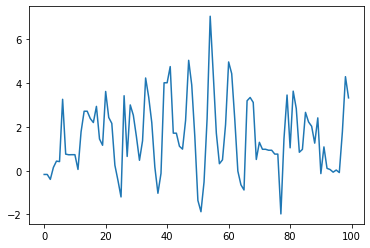

In [117]:
flattened = np.hstack([df['relationalAtt'].iloc[21][0][field] for field in df['relationalAtt'].iloc[21][0].dtype.names])
plt.plot(flattened)

In [114]:
def stack_data(df):
    # Zakładając, że każdy wiersz w df['relationalAtt'] ma 6 wymiarów
    num_dimensions = 6
    
    # Tworzymy listę do przechowywania danych dla nowego DataFrame
    new_data = [[] for _ in range(num_dimensions)]
    
    # Iterujemy przez wszystkie wiersze w df['relationalAtt']
    for row in df['relationalAtt']:
        # Sprawdzamy, czy długość row jest zgodna z oczekiwaniami
        if len(row) != num_dimensions:
            raise ValueError(f"Oczekiwana długość wiersza: {num_dimensions}, uzyskana: {len(row)}")
        
        # Dodajemy każdy wymiar do odpowiedniego miejsca w new_data
        for i in range(num_dimensions):
            new_data[i].append(row[i])
    
    # Tworzymy nowy DataFrame
    new_df = pd.DataFrame(new_data).transpose()  # transponujemy, aby każdy wiersz miał 6 wymiarów
    new_df.columns = [f'dimension_{i+1}' for i in range(num_dimensions)]
    dfs = {}

#     for column in new_df.columns:
#         dfs[column] = new_df[column].apply(pd.Series)
    
    return new_df

# Scalanie wierszy
#result_df = stack_data(df)
print(df['relationalAtt'].iloc[0].shape)

(6,)


In [110]:
result_df.shape


(40, 6)

TypeError: Cannot cast array data from dtype([('att0', '<f8'), ('att1', '<f8'), ('att2', '<f8'), ('att3', '<f8'), ('att4', '<f8'), ('att5', '<f8'), ('att6', '<f8'), ('att7', '<f8'), ('att8', '<f8'), ('att9', '<f8'), ('att10', '<f8'), ('att11', '<f8'), ('att12', '<f8'), ('att13', '<f8'), ('att14', '<f8'), ('att15', '<f8'), ('att16', '<f8'), ('att17', '<f8'), ('att18', '<f8'), ('att19', '<f8'), ('att20', '<f8'), ('att21', '<f8'), ('att22', '<f8'), ('att23', '<f8'), ('att24', '<f8'), ('att25', '<f8'), ('att26', '<f8'), ('att27', '<f8'), ('att28', '<f8'), ('att29', '<f8'), ('att30', '<f8'), ('att31', '<f8'), ('att32', '<f8'), ('att33', '<f8'), ('att34', '<f8'), ('att35', '<f8'), ('att36', '<f8'), ('att37', '<f8'), ('att38', '<f8'), ('att39', '<f8'), ('att40', '<f8'), ('att41', '<f8'), ('att42', '<f8'), ('att43', '<f8'), ('att44', '<f8'), ('att45', '<f8'), ('att46', '<f8'), ('att47', '<f8'), ('att48', '<f8'), ('att49', '<f8'), ('att50', '<f8'), ('att51', '<f8'), ('att52', '<f8'), ('att53', '<f8'), ('att54', '<f8'), ('att55', '<f8'), ('att56', '<f8'), ('att57', '<f8'), ('att58', '<f8'), ('att59', '<f8'), ('att60', '<f8'), ('att61', '<f8'), ('att62', '<f8'), ('att63', '<f8'), ('att64', '<f8'), ('att65', '<f8'), ('att66', '<f8'), ('att67', '<f8'), ('att68', '<f8'), ('att69', '<f8'), ('att70', '<f8'), ('att71', '<f8'), ('att72', '<f8'), ('att73', '<f8'), ('att74', '<f8'), ('att75', '<f8'), ('att76', '<f8'), ('att77', '<f8'), ('att78', '<f8'), ('att79', '<f8'), ('att80', '<f8'), ('att81', '<f8'), ('att82', '<f8'), ('att83', '<f8'), ('att84', '<f8'), ('att85', '<f8'), ('att86', '<f8'), ('att87', '<f8'), ('att88', '<f8'), ('att89', '<f8'), ('att90', '<f8'), ('att91', '<f8'), ('att92', '<f8'), ('att93', '<f8'), ('att94', '<f8'), ('att95', '<f8'), ('att96', '<f8'), ('att97', '<f8'), ('att98', '<f8'), ('att99', '<f8')]) to dtype('float64').

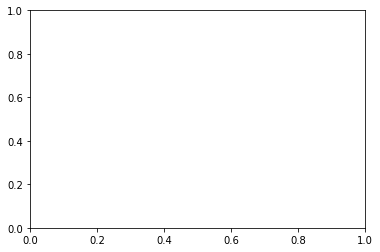

In [99]:
array = np.array(result_df.iloc[0])
plt.plot(array)